In [136]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [159]:
df = pd.read_csv("../Resources/combined_cleaned.csv")
df.head()

,id,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129487 non-null  int64  
 1   gender                             129487 non-null  object 
 2   customer_type                      129487 non-null  object 
 3   age                                129487 non-null  int64  
 4   type_of_travel                     129487 non-null  object 
 5   travel_class                       129487 non-null  object 
 6   flight_distance                    129487 non-null  int64  
 7   inflight_wifi_service              129487 non-null  int64  
 8   departure/arrival_time_convenient  129487 non-null  int64  
 9   ease_of_online_booking             129487 non-null  int64  
 10  gate_location                      129487 non-null  int64  
 11  food_and_drink                     1294

In [161]:
# FEATURE ENGINEERING

df["arrival_delay_in_minutes"] = df["arrival_delay_in_minutes"].astype('int')
df.drop(columns=["id"], inplace=True)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129487 non-null  object
 1   customer_type                      129487 non-null  object
 2   age                                129487 non-null  int64 
 3   type_of_travel                     129487 non-null  object
 4   travel_class                       129487 non-null  object
 5   flight_distance                    129487 non-null  int64 
 6   inflight_wifi_service              129487 non-null  int64 
 7   departure/arrival_time_convenient  129487 non-null  int64 
 8   ease_of_online_booking             129487 non-null  int64 
 9   gate_location                      129487 non-null  int64 
 10  food_and_drink                     129487 non-null  int64 
 11  online_boarding                    129487 non-null  

In [163]:
# Binning for columns with too many categories

# Define the custom transformer for multiple columns
class BinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bins_dict, labels_dict):
        self.bins_dict = bins_dict
        self.labels_dict = labels_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_binned = X.copy()
        for column in self.bins_dict.keys():
            X_binned[column] = pd.cut(X_binned[column], bins=self.bins_dict[column], labels=self.labels_dict[column], include_lowest=True)
        return X_binned
    # def transform(self, X):
    #     # Create bins for each feature based on the provided bins_dict
    #     binned_data = pd.DataFrame()
    #     for feature in X.columns:
    #         binned_data[feature] = pd.cut(X[feature], bins=self.bins_dict[feature], labels=self.labels_dict[feature])
    #     return binned_data

    def get_feature_names_out(self, input_features=None):
        # Generate feature names based on the labels_dict
        if input_features is None:
            return self.labels_dict.values()
        else:
            return [f"{feature}_{label}" for feature in input_features for label in self.labels_dict[feature]]

# Define bins and labels for each column
bins_dict = {
    'flight_distance': [0, 99, 199, 299, 399, 499, 599, 799, 999, 1499, 1999, 2999, 4999],
    'departure_delay_in_minutes': [0, 30, 60, 120, 180, 240, 300, 360, 420, 480, 2000],
    'arrival_delay_in_minutes': [0, 30, 60, 120, 180, 240, 300, 360, 420, 480, 2000]
}

labels_dict = {
    'flight_distance': ["0-100", "100-199", "200-299", "300-399", "400-499", "500-599", "600-799", "800-999", "1000-1499", "1500-1999", "2000-2999", "3000-4999"],
    'departure_delay_in_minutes':["0-29", "30-59", "60-119", "120-179", "180-239", "240-299", "300-359", "360-419", "420-479", "480-1999"],
    'arrival_delay_in_minutes': ["0-29", "30-59", "60-119", "120-179", "180-239", "240-299", "300-359", "360-419", "420-479", "480-1999"]
}

In [164]:
binning_transformer = BinningTransformer(bins_dict, labels_dict)
binned_df = binning_transformer.fit_transform(df)
print(binned_df.info())
binned_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   gender                             129487 non-null  object  
 1   customer_type                      129487 non-null  object  
 2   age                                129487 non-null  int64   
 3   type_of_travel                     129487 non-null  object  
 4   travel_class                       129487 non-null  object  
 5   flight_distance                    129487 non-null  category
 6   inflight_wifi_service              129487 non-null  int64   
 7   departure/arrival_time_convenient  129487 non-null  int64   
 8   ease_of_online_booking             129487 non-null  int64   
 9   gate_location                      129487 non-null  int64   
 10  food_and_drink                     129487 non-null  int64   
 11  online_boarding           

,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,100-199,5,4,3,4,3,4,3,5,5,5,5,2,5,5,30-59,30-59,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2000-2999,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0-29,0-29,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,100-199,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0-29,0-29,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3000-4999,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0-29,0-29,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1000-1499,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0-29,0-29,satisfied


In [165]:
# Change columns to strings for OneHot Encoding
binned_df["arrival_delay_in_minutes"] = binned_df["arrival_delay_in_minutes"].astype('str')
binned_df["departure_delay_in_minutes"] = binned_df["departure_delay_in_minutes"].astype('str')
binned_df["flight_distance"] = binned_df["flight_distance"].astype('str')

In [166]:
# Check binary columns for imbalance
binary_cols = ["satisfaction", "gender", "customer_type", "type_of_travel"]

for col in binary_cols:
  print(binned_df[col].value_counts())
  print()

satisfaction
neutral or dissatisfied    73225
satisfied                  56262
Name: count, dtype: int64

gender
Female    65703
Male      63784
Name: count, dtype: int64

customer_type
Loyal Customer       105773
disloyal Customer     23714
Name: count, dtype: int64

type_of_travel
Business travel    89445
Personal Travel    40042
Name: count, dtype: int64



In [167]:
# Convert binary columns into numeric values
binned_df["satisfaction"] = binned_df.satisfaction.apply(lambda x: 1 if x=="satisfied" else 0)
binned_df["gender"] = binned_df.gender.apply(lambda x: 1 if x=="Female" else 0)
binned_df["customer_type"] = binned_df.customer_type.apply(lambda x: 1 if x=="Loyal Customer" else 0)
binned_df["type_of_travel"] = binned_df.type_of_travel.apply(lambda x: 1 if x=="Business travel" else 0)

In [168]:
# Confirm numeric conversion
binary_cols = ["satisfaction", "gender", "customer_type", "type_of_travel"]
for col in binary_cols:
  print(binned_df[col].value_counts())
  print()

satisfaction
0    73225
1    56262
Name: count, dtype: int64

gender
1    65703
0    63784
Name: count, dtype: int64

customer_type
1    105773
0     23714
Name: count, dtype: int64

type_of_travel
1    89445
0    40042
Name: count, dtype: int64



## Preprocessing Pipeline

In [169]:
# Confirm data types are appropriate for preprocessing pipeline
binned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129487 non-null  int64 
 1   customer_type                      129487 non-null  int64 
 2   age                                129487 non-null  int64 
 3   type_of_travel                     129487 non-null  int64 
 4   travel_class                       129487 non-null  object
 5   flight_distance                    129487 non-null  object
 6   inflight_wifi_service              129487 non-null  int64 
 7   departure/arrival_time_convenient  129487 non-null  int64 
 8   ease_of_online_booking             129487 non-null  int64 
 9   gate_location                      129487 non-null  int64 
 10  food_and_drink                     129487 non-null  int64 
 11  online_boarding                    129487 non-null  

In [171]:
df_prep = binned_df.copy()
df_prep.drop(columns=["satisfaction"], inplace=True)
df_prep.shape

(129487, 22)

In [172]:
# # Label Encoding for binary features

# class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.encoder = OrdinalEncoder()

#     def fit(self, X, y=None):
#         self.encoder.fit(X)
#         return self

#     def transform(self, X):
#         # Transform the data and convert it back to a DataFrame
#         X_encoded = self.encoder.transform(X)
#         return pd.DataFrame(X_encoded, columns=self.encoder.get_feature_names_out(input_features=X.columns))
        
binary_features = ['gender', 'customer_type', 'type_of_travel']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    # ('ordinal_encoder', OrdinalEncoderTransformer())
])
print("Binary Features:", binary_features)

Binary Features: ['gender', 'customer_type', 'type_of_travel']


In [173]:
# Scaling for numeric features
numeric_features = ['age', 'inflight_wifi_service',
       'departure/arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
print("Numeric Features:", numeric_features)

Numeric Features: ['age', 'inflight_wifi_service', 'departure/arrival_time_convenient', 'ease_of_online_booking', 'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort', 'inflight_entertainment', 'on-board_service', 'leg_room_service', 'baggage_handling', 'checkin_service', 'inflight_service', 'cleanliness']


In [174]:
# One-Hot Encoding for categorical features 
categorical_features = ['travel_class', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    # Set sparse_output=False to return a dense array
    ])
print("Categorical Features:", categorical_features)

Categorical Features: ['travel_class', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']


In [175]:
preprocessor = ColumnTransformer(
    transformers=[
        # ('binning', BinningTransformer(bins_dict=bins_dict, labels_dict=labels_dict), 
        #      ['flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']),
        ('numeric', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [176]:
# Create and test pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform DataFrame 
df_transformed = pipeline.fit_transform(df_prep)
print(df_transformed.shape)
print(type(df_transformed))

# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features + binary_features + 
    list(preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_features)))
print(len(encoded_feature_names))
# print("\n".join(encoded_feature_names))

df_pipe = pd.DataFrame(df_transformed, columns=encoded_feature_names)
print(df_pipe.shape)
df_pipe.head()

(129487, 53)
<class 'numpy.ndarray'>
53
(129487, 53)


,age,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,gender,customer_type,type_of_travel,travel_class_Business,travel_class_Eco,travel_class_Eco Plus,flight_distance_0-100,flight_distance_100-199,flight_distance_1000-1499,flight_distance_1500-1999,flight_distance_200-299,flight_distance_2000-2999,flight_distance_300-399,flight_distance_3000-4999,flight_distance_400-499,flight_distance_500-599,flight_distance_600-799,flight_distance_800-999,departure_delay_in_minutes_0-29,departure_delay_in_minutes_120-179,departure_delay_in_minutes_180-239,departure_delay_in_minutes_240-299,departure_delay_in_minutes_30-59,departure_delay_in_minutes_300-359,departure_delay_in_minutes_360-419,departure_delay_in_minutes_420-479,departure_delay_in_minutes_480-1999,departure_delay_in_minutes_60-119,arrival_delay_in_minutes_0-29,arrival_delay_in_minutes_120-179,arrival_delay_in_minutes_180-239,arrival_delay_in_minutes_240-299,arrival_delay_in_minutes_30-59,arrival_delay_in_minutes_300-359,arrival_delay_in_minutes_360-419,arrival_delay_in_minutes_420-479,arrival_delay_in_minutes_480-1999,arrival_delay_in_minutes_60-119
0,0.831567,1.708851,0.617410,0.173519,0.800227,-0.153910,0.553276,-0.334749,1.230701,1.256225,1.252860,1.159342,-1.031669,1.153847,1.304624,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.226807,-1.300410,-1.347508,0.173519,-1.546271,1.349963,0.553276,1.181364,0.481157,0.479240,0.493055,0.311941,-0.241868,0.303947,1.304624,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.285180,-0.548095,-2.002480,-0.539923,0.800227,-0.905846,-0.927497,-1.092806,-1.017931,0.479240,-1.786361,-0.535461,-1.031669,-1.395853,-0.979144,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.302380,-2.052726,-2.002480,-1.966806,-0.764105,-0.153910,0.553276,0.423307,-1.767475,-1.851712,-1.786361,-2.230265,-0.241868,-2.245753,0.543368,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.633122,-0.548095,-0.037562,0.886960,0.018061,0.598027,-1.667884,-1.092806,-1.017931,-1.074728,-1.026556,-1.382863,0.547933,-1.395853,0.543368,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# feature_names = []

# # # Get feature names from the binning transformer if applicable
# # if hasattr(pipeline.named_steps['preprocessor'].named_transformers_['binning'], 'get_feature_names_out'):
# #     binned_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['binning'].get_feature_names_out()
# #     feature_names.extend(binned_feature_names)
# # else:
# #     # If it doesn't provide feature names, you can manually define them based on your bins
# #     for feature in ['flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']:
# #         feature_names.extend([f"{feature}_{label}" for label in labels_dict[feature]])
# # print("\n".join(feature_names))

# # # Get feature names from the binary transformer
# # if hasattr(pipeline.named_steps['preprocessor'].named_transformers_['binary'], 'get_feature_names_out'):
# #     binary_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['binary'].get_feature_names_out()
# #     feature_names.extend(binary_feature_names)

# # Get feature names from the numeric transformer
# if hasattr(pipeline.named_steps['preprocessor'].named_transformers_['numeric'], 'get_feature_names_out'):
#     numeric_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['numeric'].get_feature_names_out()
#     feature_names.extend(numeric_feature_names)

# # Get feature names from the categorical transformer
# if hasattr(pipeline.named_steps['preprocessor'].named_transformers_['categorical'], 'get_feature_names_out'):
#     categorical_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['categorical'].get_feature_names_out()
#     feature_names.extend(categorical_feature_names)
#     print(len(feature_names))
#     print("\n".join(feature_names))

# df_pipe.columns = feature_names

In [177]:
df_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 53 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   age                                  129487 non-null  float64
 1   inflight_wifi_service                129487 non-null  float64
 2   departure/arrival_time_convenient    129487 non-null  float64
 3   ease_of_online_booking               129487 non-null  float64
 4   gate_location                        129487 non-null  float64
 5   food_and_drink                       129487 non-null  float64
 6   online_boarding                      129487 non-null  float64
 7   seat_comfort                         129487 non-null  float64
 8   inflight_entertainment               129487 non-null  float64
 9   on-board_service                     129487 non-null  float64
 10  leg_room_service                     129487 non-null  float64
 11  baggage_handl

In [178]:
df_pipe = df_pipe.astype('int')
df_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 53 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   age                                  129487 non-null  int32
 1   inflight_wifi_service                129487 non-null  int32
 2   departure/arrival_time_convenient    129487 non-null  int32
 3   ease_of_online_booking               129487 non-null  int32
 4   gate_location                        129487 non-null  int32
 5   food_and_drink                       129487 non-null  int32
 6   online_boarding                      129487 non-null  int32
 7   seat_comfort                         129487 non-null  int32
 8   inflight_entertainment               129487 non-null  int32
 9   on-board_service                     129487 non-null  int32
 10  leg_room_service                     129487 non-null  int32
 11  baggage_handling                     12

In [179]:
df_pipe.columns

Index(['age', 'inflight_wifi_service', 'departure/arrival_time_convenient',
       'ease_of_online_booking', 'gate_location', 'food_and_drink',
       'online_boarding', 'seat_comfort', 'inflight_entertainment',
       'on-board_service', 'leg_room_service', 'baggage_handling',
       'checkin_service', 'inflight_service', 'cleanliness', 'gender',
       'customer_type', 'type_of_travel', 'travel_class_Business',
       'travel_class_Eco', 'travel_class_Eco Plus', 'flight_distance_0-100',
       'flight_distance_100-199', 'flight_distance_1000-1499',
       'flight_distance_1500-1999', 'flight_distance_200-299',
       'flight_distance_2000-2999', 'flight_distance_300-399',
       'flight_distance_3000-4999', 'flight_distance_400-499',
       'flight_distance_500-599', 'flight_distance_600-799',
       'flight_distance_800-999', 'departure_delay_in_minutes_0-29',
       'departure_delay_in_minutes_120-179',
       'departure_delay_in_minutes_180-239',
       'departure_delay_in_minutes

<Axes: >

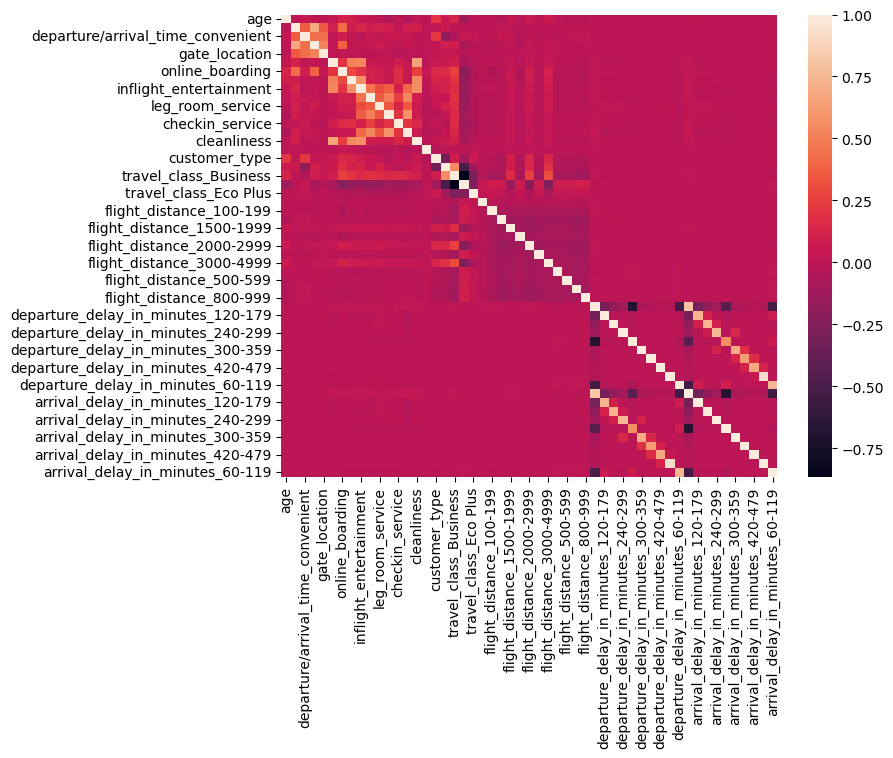

In [180]:
# View possible feature correlations
corrs = df_pipe.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corrs)

In [181]:
# Split preprocessed data into features and target arrays
X = binned_df.drop(columns=["satisfaction"])
y = binned_df.satisfaction
X.shape

(129487, 22)

In [182]:
y.value_counts()

satisfaction
0    73225
1    56262
Name: count, dtype: int64

In [183]:
# Split the preprocessed data into a training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(97115, 22) (32372, 22)
(97115,) (32372,)


In [184]:
print(X_train.columns)
X_train.head()
# Unscaled, unencoded

Index(['gender', 'customer_type', 'age', 'type_of_travel', 'travel_class',
       'flight_distance', 'inflight_wifi_service',
       'departure/arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes',
       'arrival_delay_in_minutes'],
      dtype='object')


,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes
51117,0,1,32,0,Eco,1500-1999,3,5,4,3,4,4,4,4,3,4,4,4,4,4,0-29,0-29
102367,0,1,44,1,Eco,1500-1999,1,4,3,4,2,1,2,2,1,3,3,3,4,2,0-29,0-29
78188,0,1,33,1,Business,3000-4999,2,5,5,5,2,2,2,2,4,1,3,3,3,2,0-29,0-29
7032,1,1,25,1,Business,500-599,1,5,5,5,1,2,1,1,3,4,4,2,4,1,0-29,0-29
73647,0,1,20,0,Business,800-999,4,4,4,4,4,4,4,1,4,4,3,4,1,4,360-419,300-359


## Model Experimentation

In [185]:
# FUNCTION FOR CLASSIFICATION MODELING

def classificationModeling(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)

    train_results = f"""TRAIN METRICS
    Train Confusion Matrix:
    {train_cf}

    Train Classification Report:
    {train_cr}

    Train AUC: {train_auc}
    """

    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)

    test_results = f"""TEST METRICS
    Test Confusion Matrix:
    {test_cf}

    Test Classification Report:
    {test_cr}

    Test AUC: {test_auc}
    """

    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')

    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

### Logistic Regression

TRAIN METRICS
    Train Confusion Matrix:
    [[49646  5273]
 [ 6874 35322]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.88      0.90      0.89     54919
           1       0.87      0.84      0.85     42196

    accuracy                           0.87     97115
   macro avg       0.87      0.87      0.87     97115
weighted avg       0.87      0.87      0.87     97115


    Train AUC: 0.927257562055502
    
TEST METRICS
    Test Confusion Matrix:
    [[16551  1755]
 [ 2367 11699]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.87      0.90      0.89     18306
           1       0.87      0.83      0.85     14066

    accuracy                           0.87     32372
   macro avg       0.87      0.87      0.87     32372
weighted avg       0.87      0.87      0.87     32372


    Test AUC: 0.9251769323525442
    


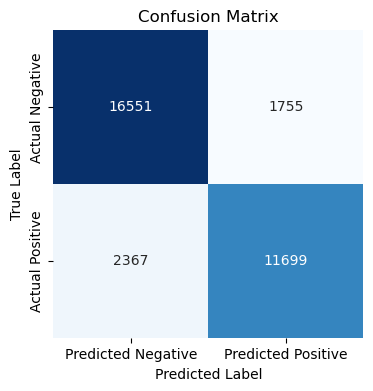

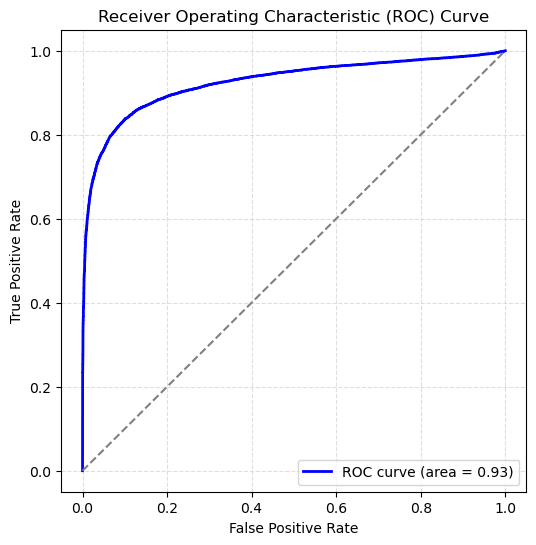

In [186]:
# Initiate the model
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state = 42))
])

# Machine Learning
classificationModeling(lr, X_train, X_test, y_train, y_test)

### Random Forest Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54918     1]
 [    1 42195]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     54919
           1       1.00      1.00      1.00     42196

    accuracy                           1.00     97115
   macro avg       1.00      1.00      1.00     97115
weighted avg       1.00      1.00      1.00     97115


    Train AUC: 0.9999999989211872
    
TEST METRICS
    Test Confusion Matrix:
    [[17913   393]
 [  901 13165]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.98      0.97     18306
           1       0.97      0.94      0.95     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.96      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9927660215379885
    


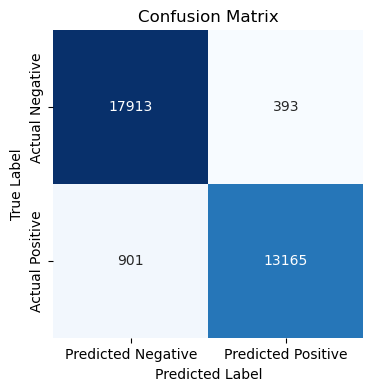

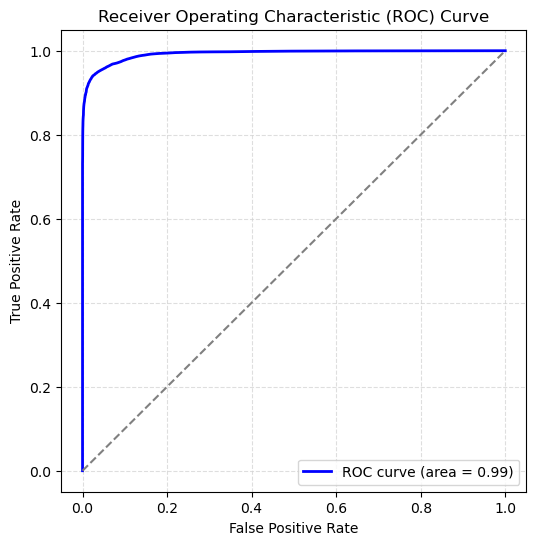

In [187]:
# Initiate the model
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(rf, X_train, X_test, y_train, y_test)

### K-Nearest Neighbors

TRAIN METRICS
    Train Confusion Matrix:
    [[53007  1912]
 [ 4682 37514]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.92      0.97      0.94     54919
           1       0.95      0.89      0.92     42196

    accuracy                           0.93     97115
   macro avg       0.94      0.93      0.93     97115
weighted avg       0.93      0.93      0.93     97115


    Train AUC: 0.9849849047588904
    
TEST METRICS
    Test Confusion Matrix:
    [[17592   714]
 [ 1745 12321]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.96      0.93     18306
           1       0.95      0.88      0.91     14066

    accuracy                           0.92     32372
   macro avg       0.93      0.92      0.92     32372
weighted avg       0.93      0.92      0.92     32372


    Test AUC: 0.9790397764132628
    


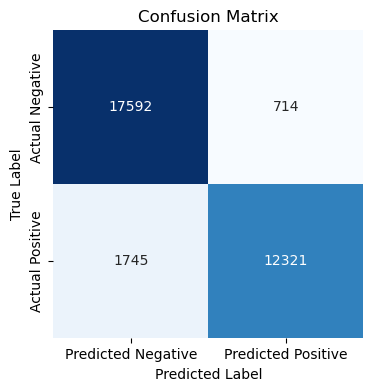

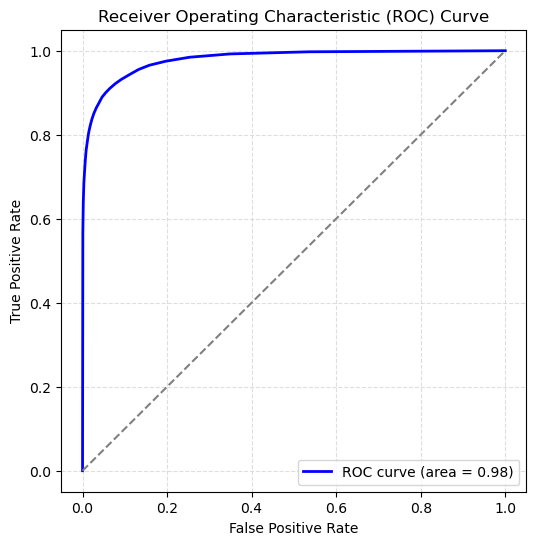

In [189]:
# Initiate the model
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=25))
])

# Machine Learning
classificationModeling(knn, X_train, X_test, y_train, y_test)

### Extra Trees Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54919     0]
 [    1 42195]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     54919
           1       1.00      1.00      1.00     42196

    accuracy                           1.00     97115
   macro avg       1.00      1.00      1.00     97115
weighted avg       1.00      1.00      1.00     97115


    Train AUC: 0.9999999997842375
    
TEST METRICS
    Test Confusion Matrix:
    [[17861   445]
 [  977 13089]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.98      0.96     18306
           1       0.97      0.93      0.95     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.95      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9916501022811581
    


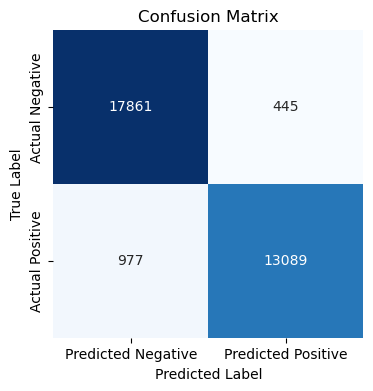

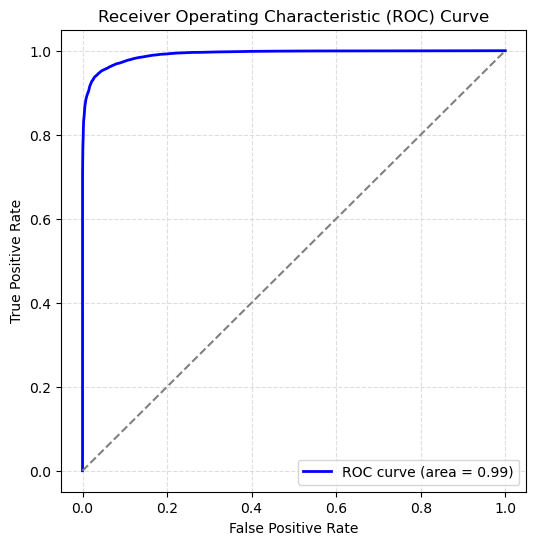

In [190]:
# Initiate the model
et = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ExtraTreesClassifier(random_state=42))
])

# Machine Learning
classificationModeling(et, X_train, X_test, y_train, y_test)

### Adaptive Boost Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[51646  3273]
 [ 3890 38306]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.93      0.94      0.94     54919
           1       0.92      0.91      0.91     42196

    accuracy                           0.93     97115
   macro avg       0.93      0.92      0.92     97115
weighted avg       0.93      0.93      0.93     97115


    Train AUC: 0.9775640952005135
    
TEST METRICS
    Test Confusion Matrix:
    [[17200  1106]
 [ 1304 12762]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.93      0.94      0.93     18306
           1       0.92      0.91      0.91     14066

    accuracy                           0.93     32372
   macro avg       0.92      0.92      0.92     32372
weighted avg       0.93      0.93      0.93     32372


    Test AUC: 0.9771903456056587
    


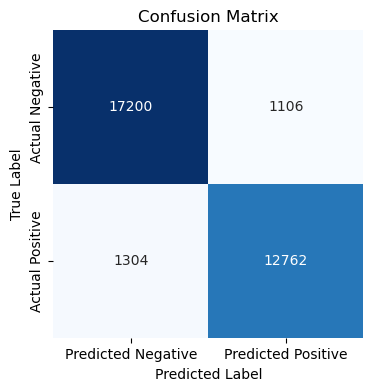

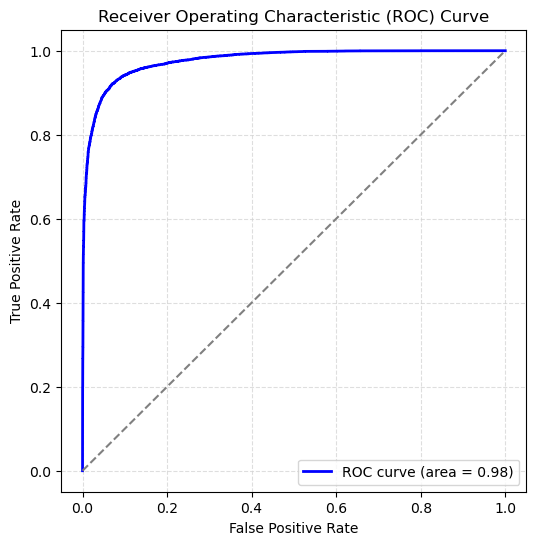

In [191]:
# Initiate the model
ada = Pipeline([
    ('preprocessor', preprocessor),
    ('model', AdaBoostClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(ada, X_train, X_test, y_train, y_test)

### Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[52666  2253]
 [ 3290 38906]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.94      0.96      0.95     54919
           1       0.95      0.92      0.93     42196

    accuracy                           0.94     97115
   macro avg       0.94      0.94      0.94     97115
weighted avg       0.94      0.94      0.94     97115


    Train AUC: 0.9876984517418478
    
TEST METRICS
    Test Confusion Matrix:
    [[17528   778]
 [ 1137 12929]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.94      0.96      0.95     18306
           1       0.94      0.92      0.93     14066

    accuracy                           0.94     32372
   macro avg       0.94      0.94      0.94     32372
weighted avg       0.94      0.94      0.94     32372


    Test AUC: 0.9867954833085504
    


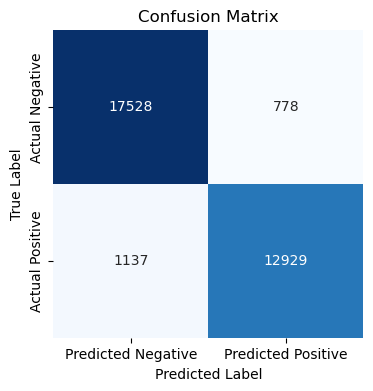

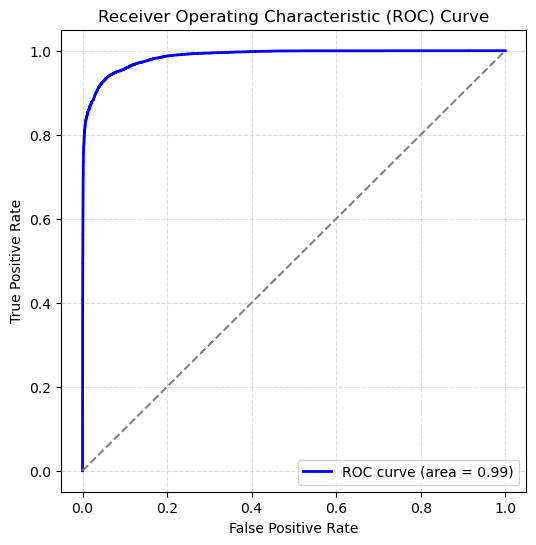

In [192]:
# Initiate the model
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(gb, X_train, X_test, y_train, y_test)

### Extra Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54259   660]
 [ 1761 40435]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.97      0.99      0.98     54919
           1       0.98      0.96      0.97     42196

    accuracy                           0.98     97115
   macro avg       0.98      0.97      0.97     97115
weighted avg       0.98      0.98      0.98     97115


    Train AUC: 0.9979027440512357
    
TEST METRICS
    Test Confusion Matrix:
    [[17895   411]
 [  833 13233]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.96      0.98      0.97     18306
           1       0.97      0.94      0.96     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.96      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9947537982859876
    


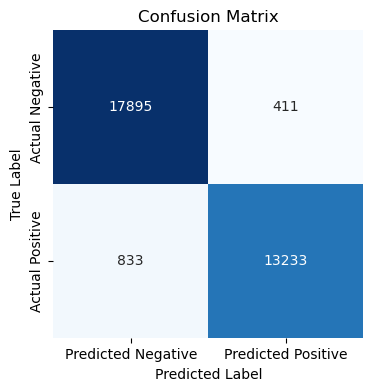

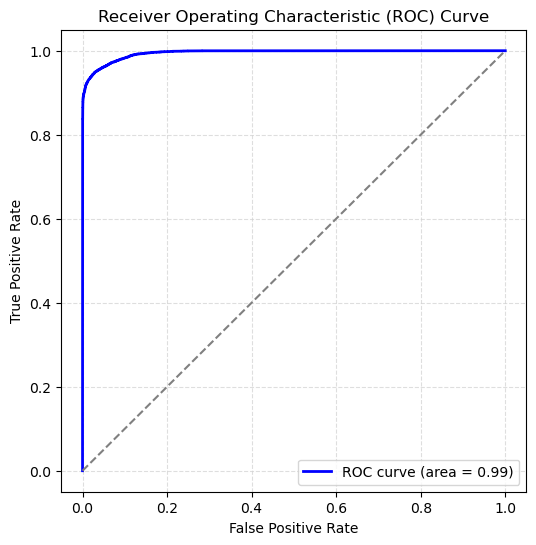

In [193]:
# Initiate the model
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(xgb, X_train, X_test, y_train, y_test)

### Light Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54001   918]
 [ 2366 39830]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.96      0.98      0.97     54919
           1       0.98      0.94      0.96     42196

    accuracy                           0.97     97115
   macro avg       0.97      0.96      0.97     97115
weighted avg       0.97      0.97      0.97     97115


    Train AUC: 0.9958184392505417
    
TEST METRICS
    Test Confusion Matrix:
    [[17933   373]
 [  890 13176]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.98      0.97     18306
           1       0.97      0.94      0.95     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.96      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9944829221154337
    


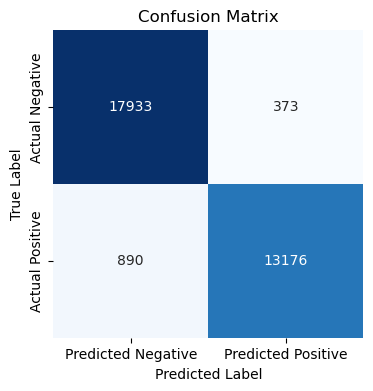

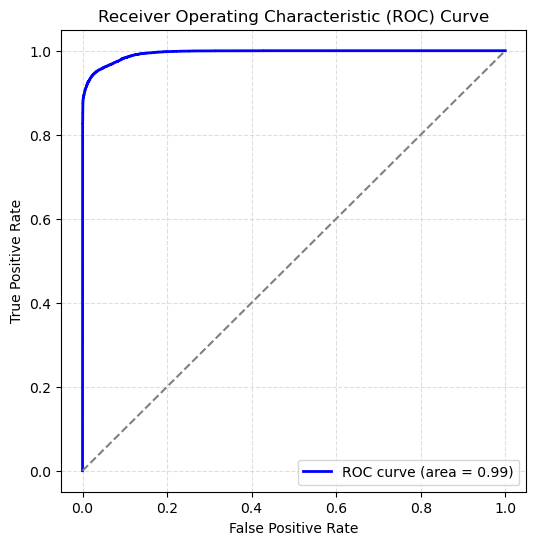

In [196]:
# Initiate the model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state = 42, verbose=-1))
])

# Machine Learning
classificationModeling(lgbm, X_train, X_test, y_train, y_test)

## Logistic Regression

TRAIN METRICS
    Train Confusion Matrix:
    [[49646  5273]
 [ 6874 35322]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.88      0.90      0.89     54919
           1       0.87      0.84      0.85     42196

    accuracy                           0.87     97115
   macro avg       0.87      0.87      0.87     97115
weighted avg       0.87      0.87      0.87     97115


    Train AUC: 0.927257562055502
    
TEST METRICS
    Test Confusion Matrix:
    [[16551  1755]
 [ 2367 11699]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.87      0.90      0.89     18306
           1       0.87      0.83      0.85     14066

    accuracy                           0.87     32372
   macro avg       0.87      0.87      0.87     32372
weighted avg       0.87      0.87      0.87     32372


    Test AUC: 0.9251769323525442
    


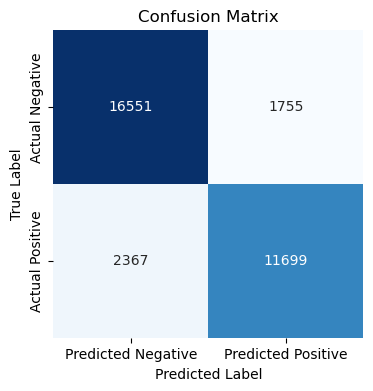

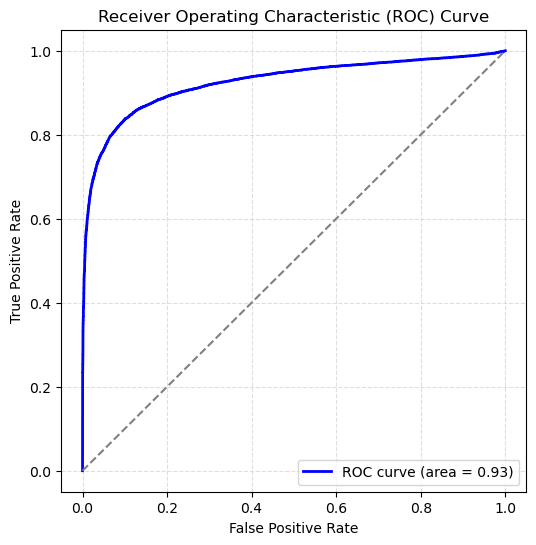

In [186]:
# Initiate the model
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state = 42))
])

# Machine Learning
classificationModeling(lr, X_train, X_test, y_train, y_test)

## Random Forest Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54918     1]
 [    1 42195]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     54919
           1       1.00      1.00      1.00     42196

    accuracy                           1.00     97115
   macro avg       1.00      1.00      1.00     97115
weighted avg       1.00      1.00      1.00     97115


    Train AUC: 0.9999999989211872
    
TEST METRICS
    Test Confusion Matrix:
    [[17913   393]
 [  901 13165]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.98      0.97     18306
           1       0.97      0.94      0.95     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.96      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9927660215379885
    


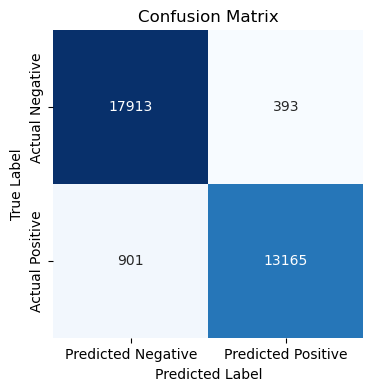

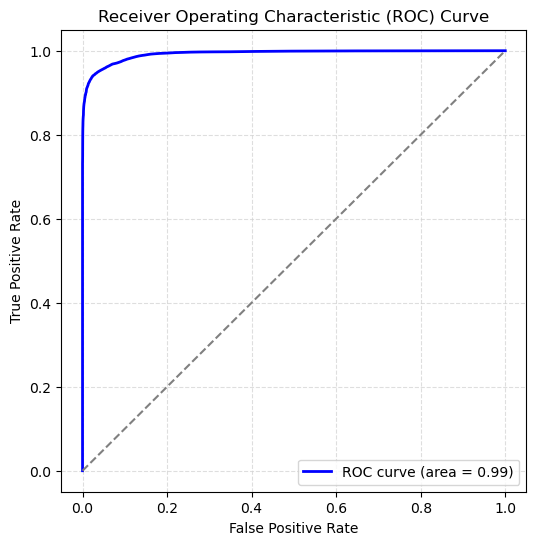

In [187]:
# Initiate the model
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(rf, X_train, X_test, y_train, y_test)

## K-Nearest Neighbors

TRAIN METRICS
    Train Confusion Matrix:
    [[53007  1912]
 [ 4682 37514]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.92      0.97      0.94     54919
           1       0.95      0.89      0.92     42196

    accuracy                           0.93     97115
   macro avg       0.94      0.93      0.93     97115
weighted avg       0.93      0.93      0.93     97115


    Train AUC: 0.9849849047588904
    
TEST METRICS
    Test Confusion Matrix:
    [[17592   714]
 [ 1745 12321]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.96      0.93     18306
           1       0.95      0.88      0.91     14066

    accuracy                           0.92     32372
   macro avg       0.93      0.92      0.92     32372
weighted avg       0.93      0.92      0.92     32372


    Test AUC: 0.9790397764132628
    


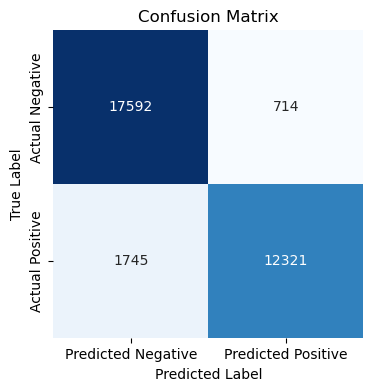

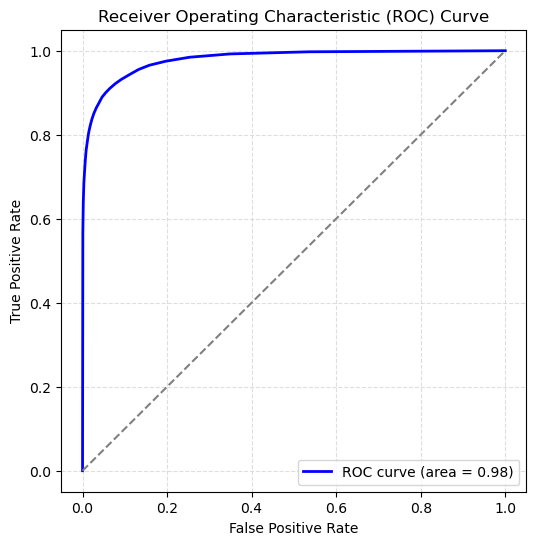

In [189]:
# Initiate the model
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=25))
])

# Machine Learning
classificationModeling(knn, X_train, X_test, y_train, y_test)

## Extra Trees Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54919     0]
 [    1 42195]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     54919
           1       1.00      1.00      1.00     42196

    accuracy                           1.00     97115
   macro avg       1.00      1.00      1.00     97115
weighted avg       1.00      1.00      1.00     97115


    Train AUC: 0.9999999997842375
    
TEST METRICS
    Test Confusion Matrix:
    [[17861   445]
 [  977 13089]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.98      0.96     18306
           1       0.97      0.93      0.95     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.95      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9916501022811581
    


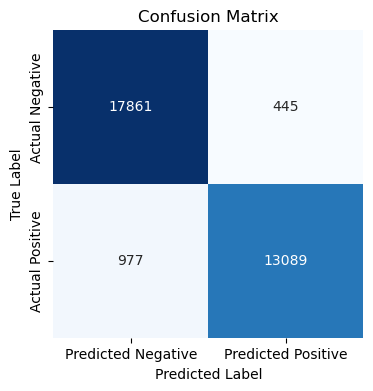

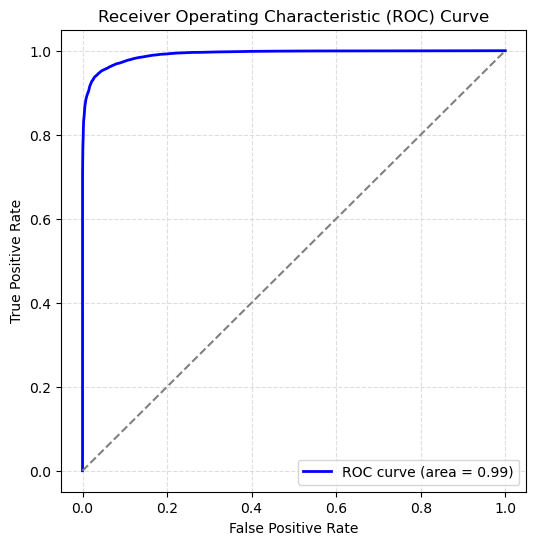

In [190]:
# Initiate the model
et = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ExtraTreesClassifier(random_state=42))
])

# Machine Learning
classificationModeling(et, X_train, X_test, y_train, y_test)

## Adaptive Boost Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[51646  3273]
 [ 3890 38306]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.93      0.94      0.94     54919
           1       0.92      0.91      0.91     42196

    accuracy                           0.93     97115
   macro avg       0.93      0.92      0.92     97115
weighted avg       0.93      0.93      0.93     97115


    Train AUC: 0.9775640952005135
    
TEST METRICS
    Test Confusion Matrix:
    [[17200  1106]
 [ 1304 12762]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.93      0.94      0.93     18306
           1       0.92      0.91      0.91     14066

    accuracy                           0.93     32372
   macro avg       0.92      0.92      0.92     32372
weighted avg       0.93      0.93      0.93     32372


    Test AUC: 0.9771903456056587
    


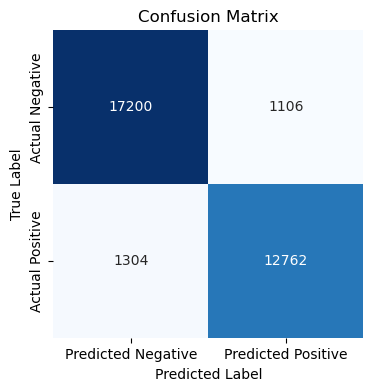

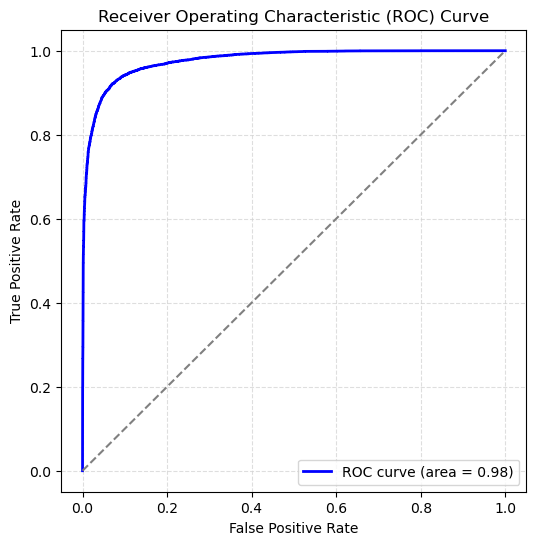

In [191]:
# Initiate the model
ada = Pipeline([
    ('preprocessor', preprocessor),
    ('model', AdaBoostClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(ada, X_train, X_test, y_train, y_test)

## Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[52666  2253]
 [ 3290 38906]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.94      0.96      0.95     54919
           1       0.95      0.92      0.93     42196

    accuracy                           0.94     97115
   macro avg       0.94      0.94      0.94     97115
weighted avg       0.94      0.94      0.94     97115


    Train AUC: 0.9876984517418478
    
TEST METRICS
    Test Confusion Matrix:
    [[17528   778]
 [ 1137 12929]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.94      0.96      0.95     18306
           1       0.94      0.92      0.93     14066

    accuracy                           0.94     32372
   macro avg       0.94      0.94      0.94     32372
weighted avg       0.94      0.94      0.94     32372


    Test AUC: 0.9867954833085504
    


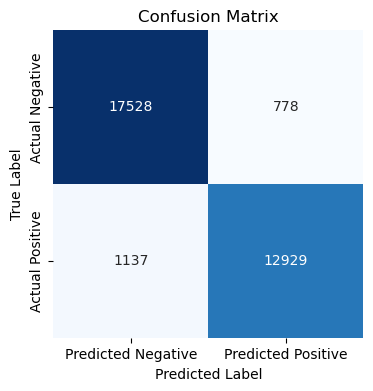

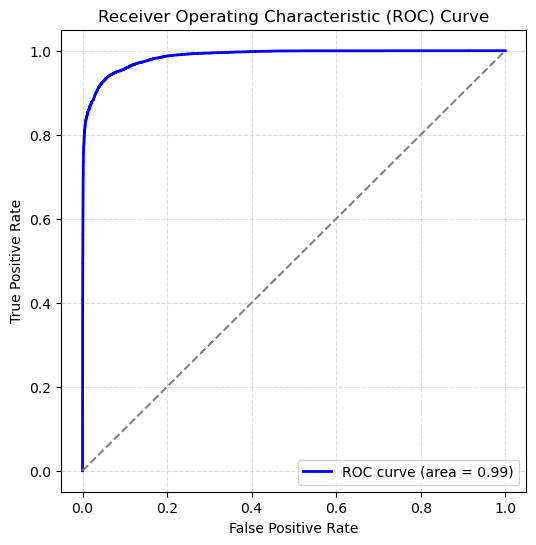

In [192]:
# Initiate the model
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(gb, X_train, X_test, y_train, y_test)

## Extra Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54259   660]
 [ 1761 40435]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.97      0.99      0.98     54919
           1       0.98      0.96      0.97     42196

    accuracy                           0.98     97115
   macro avg       0.98      0.97      0.97     97115
weighted avg       0.98      0.98      0.98     97115


    Train AUC: 0.9979027440512357
    
TEST METRICS
    Test Confusion Matrix:
    [[17895   411]
 [  833 13233]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.96      0.98      0.97     18306
           1       0.97      0.94      0.96     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.96      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9947537982859876
    


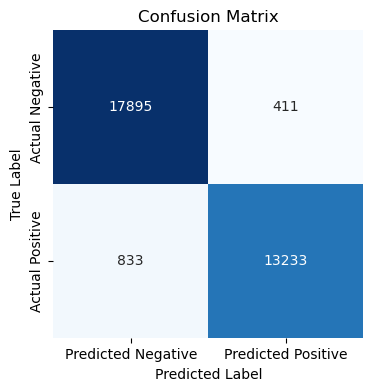

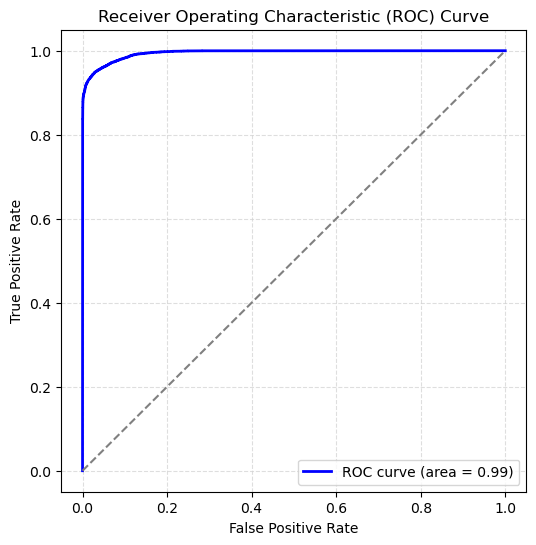

In [193]:
# Initiate the model
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(xgb, X_train, X_test, y_train, y_test)

## Light Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54001   918]
 [ 2366 39830]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.96      0.98      0.97     54919
           1       0.98      0.94      0.96     42196

    accuracy                           0.97     97115
   macro avg       0.97      0.96      0.97     97115
weighted avg       0.97      0.97      0.97     97115


    Train AUC: 0.9958184392505417
    
TEST METRICS
    Test Confusion Matrix:
    [[17933   373]
 [  890 13176]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.98      0.97     18306
           1       0.97      0.94      0.95     14066

    accuracy                           0.96     32372
   macro avg       0.96      0.96      0.96     32372
weighted avg       0.96      0.96      0.96     32372


    Test AUC: 0.9944829221154337
    


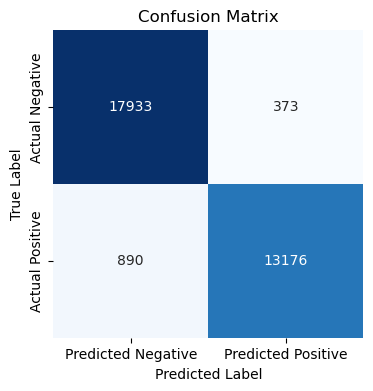

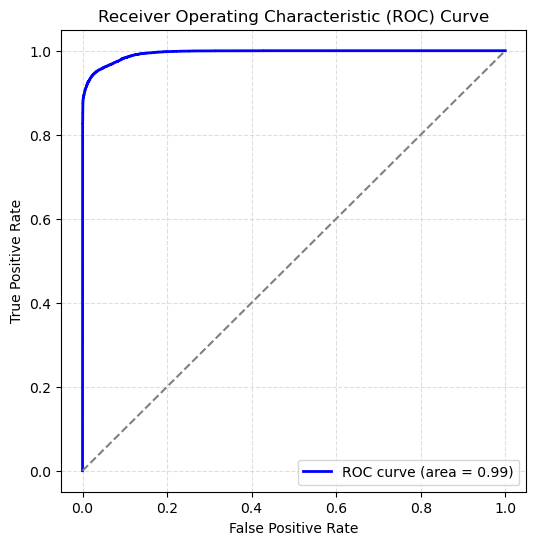

In [196]:
# Initiate the model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state = 42, verbose=-1))
])

# Machine Learning
classificationModeling(lgbm, X_train, X_test, y_train, y_test)

## Analytics

In [195]:
# XGBoost and LGBM models are the most accurate without overfitting (as seen with the RandomForest and ExtraTrees classifiers).

In [198]:
# XGB Feature Importances
fi_xgb = pd.DataFrame(list(zip(X.columns, xgb.named_steps['model'].feature_importances_)), columns=["Feature", "Importance"])
fi_xgb.sort_values(by="Importance", ascending=False)

,Feature,Importance
6,inflight_wifi_service,0.356983
17,checkin_service,0.141932
1,customer_type,0.109350
16,baggage_handling,0.063681
18,inflight_service,0.053282
8,ease_of_online_booking,0.030419
12,seat_comfort,0.027422
14,on-board_service,0.024395
11,online_boarding,0.020682
10,food_and_drink,0.017843


In [201]:
# LGBM Feature Importances
fi_lgbm = pd.DataFrame(list(zip(X.columns, lgbm.named_steps['model'].feature_importances_ / sum(lgbm.named_steps['model'].feature_importances_))), columns=["Feature", "Importance"])
fi_lgbm.sort_values(by="Importance", ascending=False)

,Feature,Importance
1,customer_type,0.172333
0,gender,0.087333
6,inflight_wifi_service,0.063333
16,baggage_handling,0.061333
11,online_boarding,0.056333
17,checkin_service,0.053333
18,inflight_service,0.053000
8,ease_of_online_booking,0.051667
7,departure/arrival_time_convenient,0.051000
4,travel_class,0.049667


In [204]:
# Cross Validation to evaluate the model on the ENTIRE dataset
# Is there bias in our train_test_split?

In [215]:
# Cross Validation on XGB model: AUC
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"XGB Cross-validation AUC scores: {cv_scores}")
print(f"XGB Mean AUC: {np.mean(cv_scores):.4f}")

XGB Cross-validation AUC scores: [0.9950422  0.99459121 0.99533666 0.99517462 0.99530591]
XGB Mean AUC: 0.9951


In [217]:
# Cross Validation on LGBM model: AUC
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"LGBM Cross-validation AUC scores: {cv_scores}")
print(f"LGBM Mean AUC: {np.mean(cv_scores):.4f}")

LGBM Cross-validation AUC scores: [0.994961   0.99443529 0.99500709 0.99488702 0.994909  ]
LGBM Mean AUC: 0.9948


In [216]:
# Cross Validation on XGB model: accuracy
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy')

# Output the results
print(f"XGB Cross-validation accuracy scores: {cv_scores}")
print(f"XGB Mean accuracy: {np.mean(cv_scores):.4f}")

XGB Cross-validation accuracy scores: [0.96428296 0.96227508 0.96350929 0.96416573 0.96586477]
XGB Mean accuracy: 0.9640


In [218]:
# Cross Validation on LGBM model: accuracy
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='accuracy')

# Output the results
print(f"LGBM Cross-validation accuracy scores: {cv_scores}")
print(f"LGBM Mean accuracy: {np.mean(cv_scores):.4f}")

LGBM Cross-validation accuracy scores: [0.96370376 0.96281566 0.96385682 0.96293007 0.96505387]
LGBM Mean accuracy: 0.9637


In [220]:
# Cross Validation on XGB model: precision
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with precision scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='precision')

# Output the results
print(f"XGB Cross-validation precision scores: {cv_scores}")
print(f"XGB Mean precision: {np.mean(cv_scores):.4f}")

XGB Cross-validation precision scores: [0.97237468 0.971809   0.96931063 0.97444853 0.97603306]
XGB Mean precision: 0.9728


In [219]:
# Cross Validation on LGBM model: precision
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with precision scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='precision')

# Output the results
print(f"LGBM Cross-validation precision scores: {cv_scores}")
print(f"LGBM Mean precision: {np.mean(cv_scores):.4f}")

LGBM Cross-validation precision scores: [0.97389946 0.974631   0.97277727 0.97683469 0.97809814]
LGBM Mean precision: 0.9752


In [221]:
# Cross Validation on XGB model: recall
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with recall scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='recall')

# Output the results
print(f"XGB Cross-validation recall scores: {cv_scores}")
print(f"XGB Mean recall: {np.mean(cv_scores):.4f}")

XGB Cross-validation recall scores: [0.94463699 0.94046032 0.94596516 0.94223249 0.94463207]
XGB Mean recall: 0.9436


In [222]:
# Cross Validation on LGBM model: recall
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with recall scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='recall')

# Output the results
print(f"LGBM Cross-validation recall scores: {cv_scores}")
print(f"LGBM Mean recall: {np.mean(cv_scores):.4f}")

LGBM Cross-validation recall scores: [0.94170443 0.93886075 0.9432101  0.93690011 0.94063278]
LGBM Mean recall: 0.9403


## Optimizing

In [225]:
# Compare features with lowest importance
fi_xgb.sort_values(by="Importance", ascending=True).head(10)

,Feature,Importance
21,arrival_delay_in_minutes,0.001747
15,leg_room_service,0.002050
19,cleanliness,0.002706
20,departure_delay_in_minutes,0.003217
5,flight_distance,0.004147
2,age,0.004887
3,type_of_travel,0.005202
0,gender,0.005398
4,travel_class,0.012823
13,inflight_entertainment,0.014509


In [226]:
fi_lgbm.sort_values(by="Importance", ascending=True).head(10)

,Feature,Importance
21,arrival_delay_in_minutes,0.000000
20,departure_delay_in_minutes,0.000667
15,leg_room_service,0.005333
19,cleanliness,0.007000
5,flight_distance,0.013667
3,type_of_travel,0.021333
2,age,0.025333
9,gate_location,0.026333
10,food_and_drink,0.030000
14,on-board_service,0.033333


In [228]:
# Drop the 7 least important features
df2 = binned_df.copy()
df2.drop(columns=[
    "arrival_delay_in_minutes", 
    "departure_delay_in_minutes", 
    "leg_room_service",
    "cleanliness", 
    "flight_distance", 
    "age", 
    "type_of_travel"],
    inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129487 non-null  int64 
 1   customer_type                      129487 non-null  int64 
 2   travel_class                       129487 non-null  object
 3   inflight_wifi_service              129487 non-null  int64 
 4   departure/arrival_time_convenient  129487 non-null  int64 
 5   ease_of_online_booking             129487 non-null  int64 
 6   gate_location                      129487 non-null  int64 
 7   food_and_drink                     129487 non-null  int64 
 8   online_boarding                    129487 non-null  int64 
 9   seat_comfort                       129487 non-null  int64 
 10  inflight_entertainment             129487 non-null  int64 
 11  on-board_service                   129487 non-null  

In [229]:
# Update preprocessing pipeline

binary_features = ['gender', 'customer_type']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    # ('ordinal_encoder', OrdinalEncoderTransformer())
])

numeric_features = ['inflight_wifi_service',
       'departure/arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on-board_service',
       'baggage_handling', 'checkin_service', 'inflight_service']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['travel_class']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    # Set sparse_output=False to return a dense array
    ])

preprocessor = ColumnTransformer(
    transformers=[
        # ('binning', BinningTransformer(bins_dict=bins_dict, labels_dict=labels_dict), 
        #      ['flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']),
        ('numeric', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [230]:
X = df2.drop(columns=["satisfaction"])
y = df2.satisfaction

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
# stratify=True maintains target class percentages
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(97115, 15) (32372, 15)
(97115,) (32372,)


### Logistic Regression

TRAIN METRICS
    Train Confusion Matrix:
    [[48245  6674]
 [ 8025 34171]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.86      0.88      0.87     54919
           1       0.84      0.81      0.82     42196

    accuracy                           0.85     97115
   macro avg       0.85      0.84      0.85     97115
weighted avg       0.85      0.85      0.85     97115


    Train AUC: 0.9067303608868338
    
TEST METRICS
    Test Confusion Matrix:
    [[16024  2282]
 [ 2726 11340]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.85      0.88      0.86     18306
           1       0.83      0.81      0.82     14066

    accuracy                           0.85     32372
   macro avg       0.84      0.84      0.84     32372
weighted avg       0.84      0.85      0.84     32372


    Test AUC: 0.9057965896566433
    


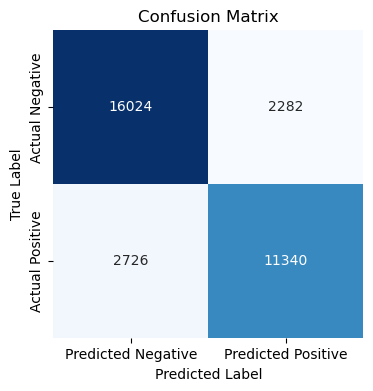

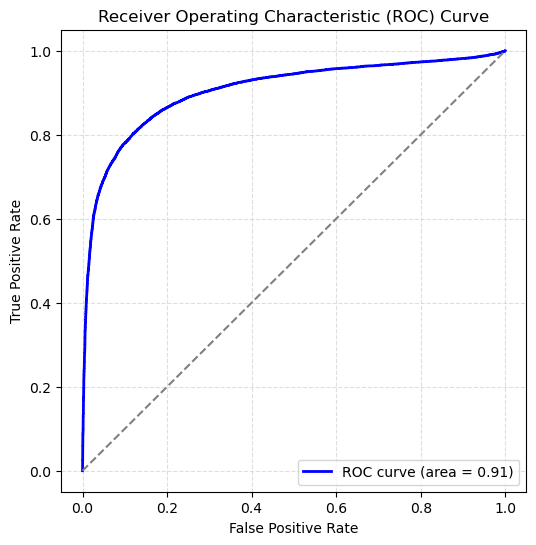

In [232]:
# Initiate the model
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state = 42))
])

# Machine Learning
classificationModeling(lr, X_train, X_test, y_train, y_test)

### Random Forest Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54762   157]
 [  212 41984]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     54919
           1       1.00      0.99      1.00     42196

    accuracy                           1.00     97115
   macro avg       1.00      1.00      1.00     97115
weighted avg       1.00      1.00      1.00     97115


    Train AUC: 0.9999447382441122
    
TEST METRICS
    Test Confusion Matrix:
    [[17708   598]
 [ 1002 13064]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.97      0.96     18306
           1       0.96      0.93      0.94     14066

    accuracy                           0.95     32372
   macro avg       0.95      0.95      0.95     32372
weighted avg       0.95      0.95      0.95     32372


    Test AUC: 0.9890644161503053
    


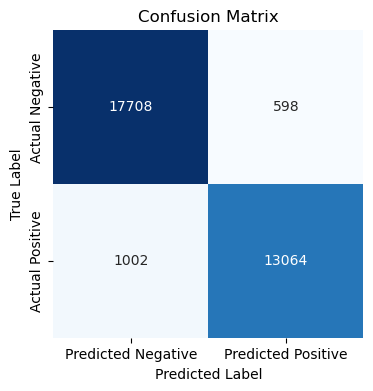

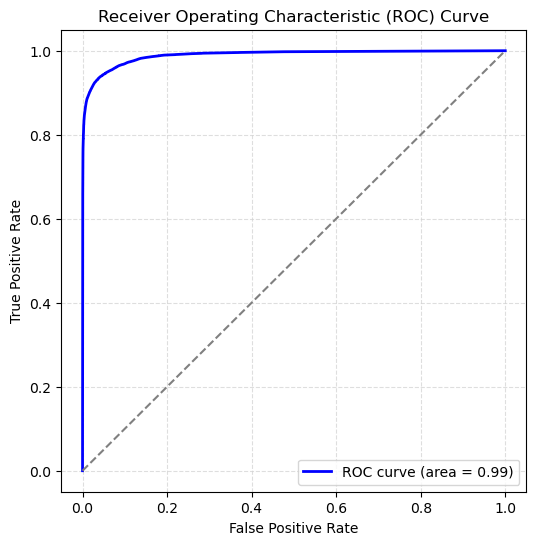

In [233]:
# Initiate the model
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(rf, X_train, X_test, y_train, y_test)

### K-Nearest Neighbors

TRAIN METRICS
    Train Confusion Matrix:
    [[52730  2189]
 [ 4683 37513]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.92      0.96      0.94     54919
           1       0.94      0.89      0.92     42196

    accuracy                           0.93     97115
   macro avg       0.93      0.92      0.93     97115
weighted avg       0.93      0.93      0.93     97115


    Train AUC: 0.9841931797708109
    
TEST METRICS
    Test Confusion Matrix:
    [[17502   804]
 [ 1719 12347]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.96      0.93     18306
           1       0.94      0.88      0.91     14066

    accuracy                           0.92     32372
   macro avg       0.92      0.92      0.92     32372
weighted avg       0.92      0.92      0.92     32372


    Test AUC: 0.9782026442463523
    


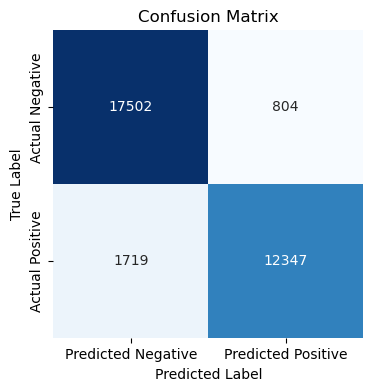

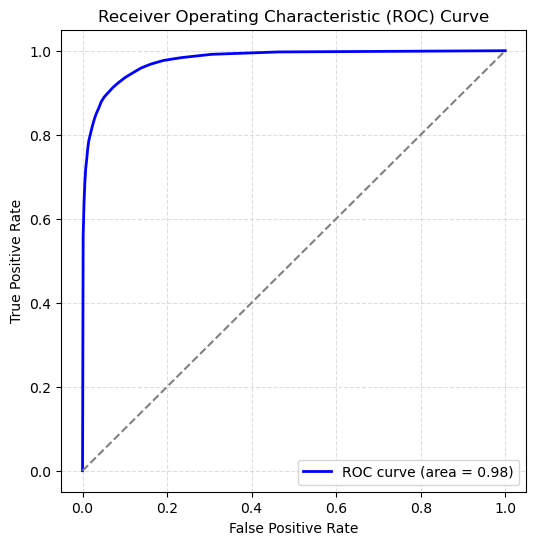

In [234]:
# Initiate the model
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=25))
])

# Machine Learning
classificationModeling(knn, X_train, X_test, y_train, y_test)

### Extra Trees Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[54882    37]
 [  329 41867]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.99      1.00      1.00     54919
           1       1.00      0.99      1.00     42196

    accuracy                           1.00     97115
   macro avg       1.00      1.00      1.00     97115
weighted avg       1.00      1.00      1.00     97115


    Train AUC: 0.9999700845201179
    
TEST METRICS
    Test Confusion Matrix:
    [[17660   646]
 [ 1013 13053]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.96      0.96     18306
           1       0.95      0.93      0.94     14066

    accuracy                           0.95     32372
   macro avg       0.95      0.95      0.95     32372
weighted avg       0.95      0.95      0.95     32372


    Test AUC: 0.9816358667429285
    


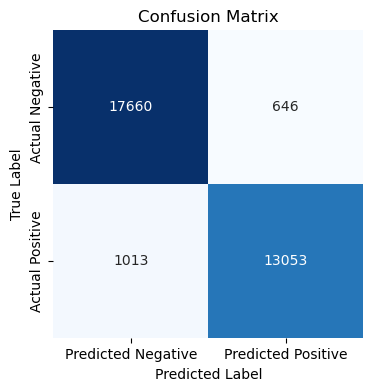

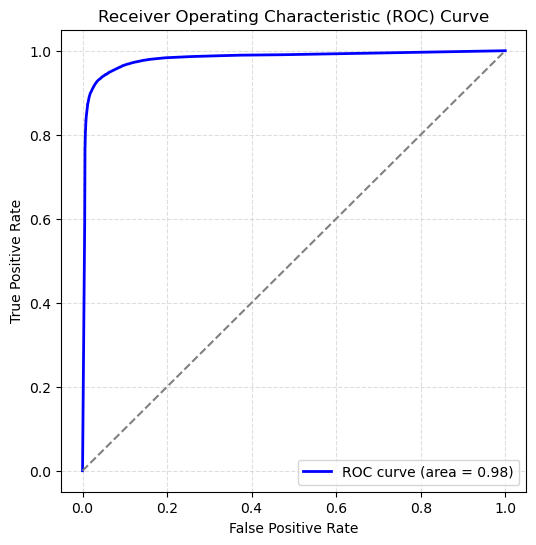

In [235]:
# Initiate the model
et = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ExtraTreesClassifier(random_state=42))
])

# Machine Learning
classificationModeling(et, X_train, X_test, y_train, y_test)

### Adaptive Boost Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[50622  4297]
 [ 5023 37173]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.92      0.92     54919
           1       0.90      0.88      0.89     42196

    accuracy                           0.90     97115
   macro avg       0.90      0.90      0.90     97115
weighted avg       0.90      0.90      0.90     97115


    Train AUC: 0.9652762422555241
    
TEST METRICS
    Test Confusion Matrix:
    [[16860  1446]
 [ 1701 12365]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.92      0.91     18306
           1       0.90      0.88      0.89     14066

    accuracy                           0.90     32372
   macro avg       0.90      0.90      0.90     32372
weighted avg       0.90      0.90      0.90     32372


    Test AUC: 0.9644051406513308
    


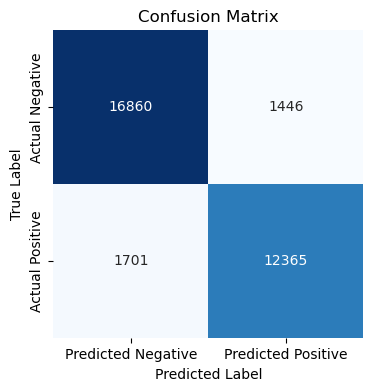

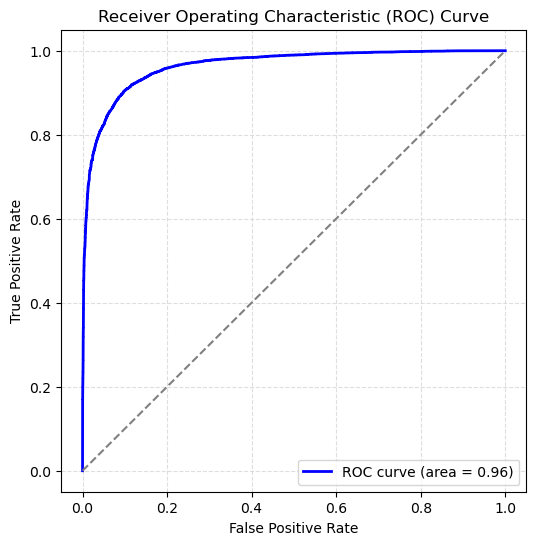

In [236]:
# Initiate the model
ada = Pipeline([
    ('preprocessor', preprocessor),
    ('model', AdaBoostClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(ada, X_train, X_test, y_train, y_test)

### Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[52175  2744]
 [ 4244 37952]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.92      0.95      0.94     54919
           1       0.93      0.90      0.92     42196

    accuracy                           0.93     97115
   macro avg       0.93      0.92      0.93     97115
weighted avg       0.93      0.93      0.93     97115


    Train AUC: 0.9810333551045818
    
TEST METRICS
    Test Confusion Matrix:
    [[17373   933]
 [ 1470 12596]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.92      0.95      0.94     18306
           1       0.93      0.90      0.91     14066

    accuracy                           0.93     32372
   macro avg       0.93      0.92      0.92     32372
weighted avg       0.93      0.93      0.93     32372


    Test AUC: 0.9800554693315832
    


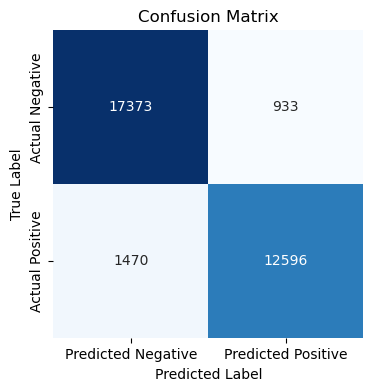

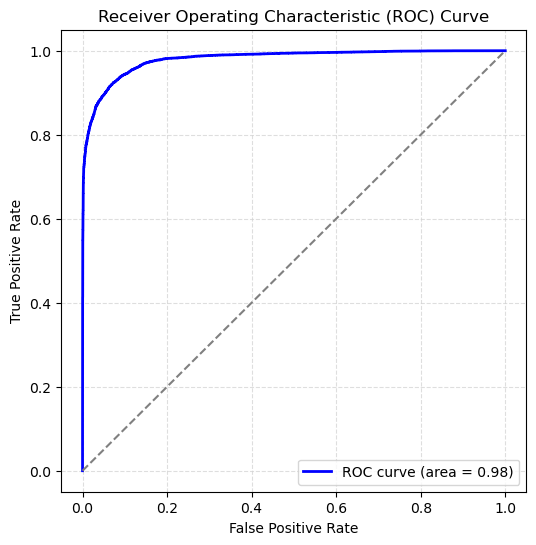

In [237]:
# Initiate the model
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(gb, X_train, X_test, y_train, y_test)

### Extra Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[53613  1306]
 [ 2204 39992]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.96      0.98      0.97     54919
           1       0.97      0.95      0.96     42196

    accuracy                           0.96     97115
   macro avg       0.96      0.96      0.96     97115
weighted avg       0.96      0.96      0.96     97115


    Train AUC: 0.9953201690457939
    
TEST METRICS
    Test Confusion Matrix:
    [[17700   606]
 [  921 13145]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.97      0.96     18306
           1       0.96      0.93      0.95     14066

    accuracy                           0.95     32372
   macro avg       0.95      0.95      0.95     32372
weighted avg       0.95      0.95      0.95     32372


    Test AUC: 0.9922221448606543
    


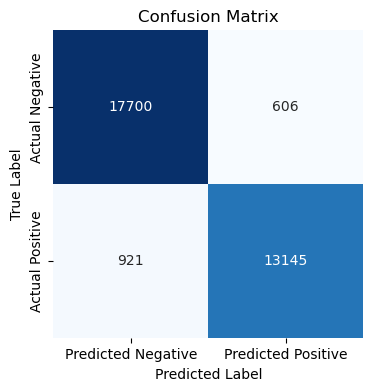

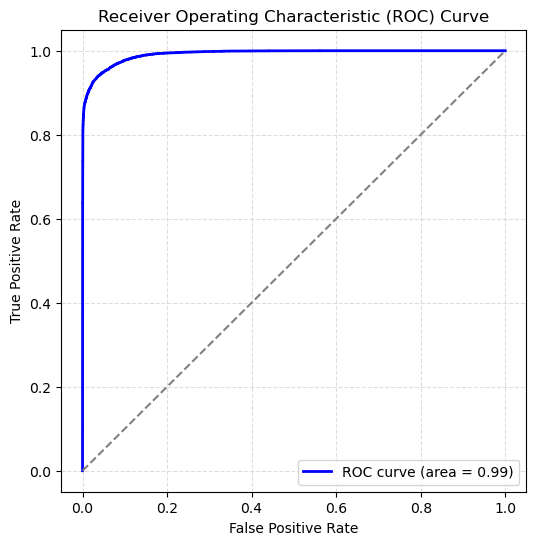

In [238]:
# Initiate the model
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state = 42))
])

# Machine Learning
classificationModeling(xgb, X_train, X_test, y_train, y_test)

### Light Gradient Boosting Classifier

TRAIN METRICS
    Train Confusion Matrix:
    [[53220  1699]
 [ 2720 39476]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.97      0.96     54919
           1       0.96      0.94      0.95     42196

    accuracy                           0.95     97115
   macro avg       0.96      0.95      0.95     97115
weighted avg       0.95      0.95      0.95     97115


    Train AUC: 0.9928285200539508
    
TEST METRICS
    Test Confusion Matrix:
    [[17697   609]
 [  993 13073]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.95      0.97      0.96     18306
           1       0.96      0.93      0.94     14066

    accuracy                           0.95     32372
   macro avg       0.95      0.95      0.95     32372
weighted avg       0.95      0.95      0.95     32372


    Test AUC: 0.991384981624841
    


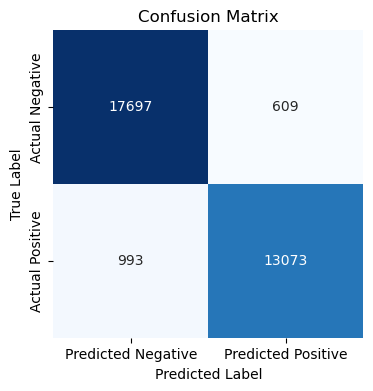

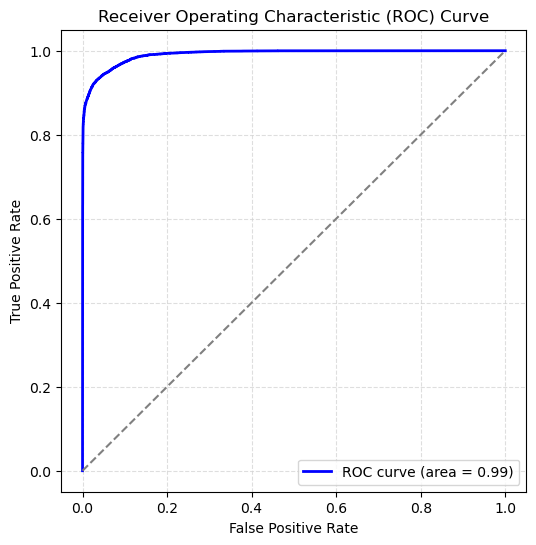

In [239]:
# Initiate the model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state = 42, verbose=-1))
])

# Machine Learning
classificationModeling(lgbm, X_train, X_test, y_train, y_test)

In [240]:
# XGB Feature Importances
fi_xgb = pd.DataFrame(list(zip(X.columns, xgb.named_steps['model'].feature_importances_)), columns=["Feature", "Importance"])
fi_xgb.sort_values(by="Importance", ascending=False)

,Feature,Importance
5,ease_of_online_booking,0.353191
14,inflight_service,0.181102
0,gender,0.168226
13,checkin_service,0.060351
7,food_and_drink,0.044284
10,inflight_entertainment,0.029081
3,inflight_wifi_service,0.024231
1,customer_type,0.024188
11,on-board_service,0.019551
6,gate_location,0.019276


In [241]:
# LGBM Feature Importances
fi_lgbm = pd.DataFrame(list(zip(X.columns, lgbm.named_steps['model'].feature_importances_ / sum(lgbm.named_steps['model'].feature_importances_))), columns=["Feature", "Importance"])
fi_lgbm.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,gender,0.174667
3,inflight_wifi_service,0.084333
5,ease_of_online_booking,0.080667
7,food_and_drink,0.075333
1,customer_type,0.073000
13,checkin_service,0.072667
14,inflight_service,0.072667
9,seat_comfort,0.066667
11,on-board_service,0.066667
6,gate_location,0.056667


In [242]:
# Cross Validation to evaluate the model on the ENTIRE dataset
# Is there bias in our train_test_split?

In [243]:
# Cross Validation on XGB model: AUC
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"XGB Cross-validation AUC scores: {cv_scores}")
print(f"XGB Mean AUC: {np.mean(cv_scores):.4f}")

XGB Cross-validation AUC scores: [0.99281271 0.99221035 0.99290972 0.99288279 0.99247204]
XGB Mean AUC: 0.9927


In [244]:
# Cross Validation on LGBM model: AUC
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with roc_auc scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='roc_auc')

# Output the results
print(f"LGBM Cross-validation AUC scores: {cv_scores}")
print(f"LGBM Mean AUC: {np.mean(cv_scores):.4f}")

LGBM Cross-validation AUC scores: [0.99157291 0.99110913 0.99198921 0.99187113 0.99155718]
LGBM Mean AUC: 0.9916


In [245]:
# Cross Validation on XGB model: accuracy
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy')

# Output the results
print(f"XGB Cross-validation accuracy scores: {cv_scores}")
print(f"XGB Mean accuracy: {np.mean(cv_scores):.4f}")

XGB Cross-validation accuracy scores: [0.95509306 0.95439802 0.95501409 0.95613392 0.95613392]
XGB Mean accuracy: 0.9554


In [246]:
# Cross Validation on LGBM model: accuracy
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with accuracy scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='accuracy')

# Output the results
print(f"LGBM Cross-validation accuracy scores: {cv_scores}")
print(f"LGBM Mean accuracy: {np.mean(cv_scores):.4f}")

LGBM Cross-validation accuracy scores: [0.95177234 0.94926249 0.95211801 0.95273584 0.95292891]
LGBM Mean accuracy: 0.9518


In [247]:
# Cross Validation on XGB model: precision
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with precision scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='precision')

# Output the results
print(f"XGB Cross-validation precision scores: {cv_scores}")
print(f"XGB Mean precision: {np.mean(cv_scores):.4f}")

XGB Cross-validation precision scores: [0.95772092 0.9584016  0.95531281 0.96057184 0.96073966]
XGB Mean precision: 0.9585


In [248]:
# Cross Validation on LGBM model: precision
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with precision scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='precision')

# Output the results
print(f"LGBM Cross-validation precision scores: {cv_scores}")
print(f"LGBM Mean precision: {np.mean(cv_scores):.4f}")

LGBM Cross-validation precision scores: [0.95332608 0.95362848 0.95509091 0.95940993 0.9582534 ]
LGBM Mean precision: 0.9559


In [249]:
# Cross Validation on XGB model: recall
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=42))
])

# Perform 5-fold cross-validation with recall scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(xgb, X, y, cv=cv, scoring='recall')

# Output the results
print(f"XGB Cross-validation recall scores: {cv_scores}")
print(f"XGB Mean recall: {np.mean(cv_scores):.4f}")

XGB Cross-validation recall scores: [0.93806096 0.9356616  0.94045503 0.93752222 0.93734447]
XGB Mean recall: 0.9378


In [250]:
# Cross Validation on LGBM model: recall
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

# Perform 5-fold cross-validation with recall scoring
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(lgbm, X, y, cv=cv, scoring='recall')

# Output the results
print(f"LGBM Cross-validation recall scores: {cv_scores}")
print(f"LGBM Mean recall: {np.mean(cv_scores):.4f}")

LGBM Cross-validation recall scores: [0.93477295 0.92837466 0.93370068 0.93059012 0.93227871]
LGBM Mean recall: 0.9319
